In [1]:

import casadi
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
from SHARED.model import *
from matplotlib.lines import Line2D
from SHARED.display_trajectories import *
import time
import timeit
from numpy import asarray
from numpy import savetxt
from SHARED.setup import *

#### ODE Model

##### Params

##### Model

In [2]:
T = (5) #Time horizon (hours)
N = (T*3600)//dT #Number of Control Actions
F,g = model_functions()
stochastic = True
num_simulations = 30 if stochastic else 1
save_data = True

# N = 1920

In [3]:
print (N)

10


#### Optimal Control

Objective Functions: $\newline$
J1 = $$\min_{u(k),y(k)} \sum_{k = k_0}^{k_0 + N_p} (V(y(k),u(k),d(k)))= \sum_{k = k_0}^{k_0 + N_p} -q_{y_1} \cdot y_1(k) + q_{u_1}\cdot u_1(k) +  q_{u_2}\cdot u_2(k) + q_{u_3}\cdot u_3(k)$$
$$s.t.$$
$$x(k+1) = F(x(k),u(k),d(k),p), \quad y(k) = g(x(k),p)$$
$$u_{min} \le u(k) \le u_{max}, \quad |u(k) - u(k-1)| \le \delta u$$
$$y_{min}(k) \le y(k) \le y_{max}(k), \quad \forall k=k_0,\dots,k0+N_p $$
$$x(k_0) = x_0$$

In [4]:
print (N)

10


In [5]:
opti = casadi.Opti()
mpc_reward = partial(reward_function, return_type = "DM")



#State Variables
X = opti.variable(4,N+1)    #->Drymass              (kg/m2)
                            #->Indoor C02           (kg/m3)
                            #->Indoor Temp          (deg C)
                            #->Indoor Humidity      (kg/m3)
#Output Variables
Y  = opti.variable(4,N)     #->Drymass              (kg/m2)
                            #->Indoor C02           (ppm)
                            #->Indoor Temp          (deg C)
                            #->Indoor Humidity      (%)
#Disturbance Variables
D = opti.parameter(4,N)     #->Irradiance           (W/m2)
                            #->Outdoor C02          (kg/m3)
                            #->Outdoor Temp         (deg C)
                            #->Outdoor Humidity     (kg/m3)
#Control Variables
U = opti.variable(3,N)      #->C02 Injection        (mg/(m2.s))
                            #->Ventilation          (mm/s)
                            #->Heating              (W/m2)

P = opti.variable (4,N)     #Penalties for temp ub and lb, co2 ub and lb                  
                            
#Initial Values
px = opti.parameter(4,1)             #initial state
pu = opti.parameter(3,1)             #initial control action

# lam_g = opti.
# lamx = 



#Set Parameters
opti.set_value(D,casadi.DM.zeros(D.shape))
opti.set_value(px,x0)
opti.set_value(pu,u0)


#Cost Function
J = 0

#Set Constraints and Cost Function
for k in range(0,N):
    
    
    opti.subject_to(X[:,k+1] == F(X[:,k],U[:,k],D[:,k],nominal_params))                                #Dynamic Constraints
    opti.subject_to(Y[:,k] == g(X[:,k+1],nominal_params))                                                #Output  Constraints
    opti.subject_to(u_min <= (U[:,k] <= u_max))                                         #Input   Contraints
    
    #Linear penalty functions
    opti.subject_to(P[:,k] >= 0)
    opti.subject_to(P[0,k] >= pen_c02     * (C02_MIN_CONSTRAIN_MPC - Y[1,k]))   #C02 lb
    opti.subject_to(P[1,k] >= pen_c02     * (Y[1,k] - C02_MAX_CONSTRAIN_MPC))   #C02 ub
    opti.subject_to(P[2,k] >= pen_temp_lb * (TEMP_MIN_CONSTRAIN_MPC - Y[2,k]))             #Temp lb
    opti.subject_to(P[3,k] >= pen_temp_ub * (Y[2,k] - TEMP_MAX_CONSTRAIN_MPC))                  #Temp ub
    
         
    
    #Hard Constraints
    J -= mpc_reward(delta_drymass=(X[0,k+1]-X[0,k]), control_inputs=U[:,k])       
    # J -= mpc_reward(control_inputs=U[:,k])  
    J += (P[0,k] + P[1,k] + P[2,k] + P[3,k])    
    
    # opti.subject_to(C02_MIN_CONSTRAIN_MPC     <= (Y[1,k] <= C02_MAX_CONSTRAIN_MPC))     #C02 min max constraints
    # opti.subject_to(T_mins[0,k] <= (Y[2,k]    <= T_maxs[0,k])) #Temp min max constraints
    # opti.subject_to(HUM_MIN_CONSTRAIN         <= (Y[3,k] <= HUM_MAX_CONSTRAIN))         #Hum min max constraints
    
    if k < N-1:                                         
        opti.subject_to(-delta_u<=(U[:,k+1] - U[:,k]<=delta_u))               #Change in input Constraint

# J -= mpc_reward(delta_drymass=(X[0,N])) 
opti.subject_to(-delta_u <= (U[:,0]-pu <= delta_u))                             #Initial change in input Constraint
opti.subject_to(X[:,0] == px)                                                           #Initial Condition Constraint
opti.minimize(J)

#Solver --> ipopt, bonmin, snopt, blocksqp,sqpmethod, scpgen
opts = {}
opts["print_time"] = False
opts["ipopt.print_level"]= False
opts["verbose"] =  False
opts["ipopt.max_iter"] = 5000

# opts["ipopt.tol"] = 1 #Default: 0.0001
# opts["ipopt.constr_viol_tol"] = 1 #Default: 0.0001
# opts["ipopt.acceptable_constr_viol_tol"] = 1 #Default: 0.0001
# opts["ipopt.acceptable_tol"] = 1 #Default: 0.0001
# opts["ipopt.jac_d_constant"] = 'yes'
# opts["ipopt.acceptable_tol"] = 1e-5
opts["ipopt.bound_relax_factor"] = 1e-3

opts["ipopt.nlp_scaling_method"]       = 'gradient-based'
# opts["ipopt.warm_start_same_structure"]       = 'yes'
# opts["ipopt.warm_start_init_point"]    = 'yes'
opts["ipopt.warm_start_entire_iterate"]    = 'yes'
# opts["ipopt.bound_push"] = 0.5
# opts["ipopt.bound_frac"] = 0.5
# opts["ipopt.slack_bound_push"] = 0.5
# opts["ipopt.slack_bound_frac"] = 0.5
# opts["ipopt.max_cpu_time"] = 0.1


# s_opts = {"max_cpu_time": 0.1, 
# 				  "print_level": 0, 
# 				  "tol": 5e-1, 
# 				  "dual_inf_tol": 5.0, 
# 				  "constr_viol_tol": 1e-1,
# 				  "compl_inf_tol": 1e-1, 
# 				  "acceptable_tol": 1e-2, 
# 				  "acceptable_constr_viol_tol": 0.01, 
# 				  "acceptable_dual_inf_tol": 1e10,
# 				  "acceptable_compl_inf_tol": 0.01,
# 				  "acceptable_obj_change_tol": 1e20,
# 				  "diverging_iterates_tol": 1e20}
s_opts = { "constr_viol_tol": 0.01,
            "acceptable_constr_viol_tol": 0.1, 
            "acceptable_tol": 1e-2, 
}

opti.solver('ipopt',opts,s_opts,)
# sol = opti.solve()
MPC = opti.to_function('MPC',[px,D,pu],[U[:,0],U,X],['px','D','pu'],['u_opt','u_traj','x_traj'])
MPC.save('MPC/MPC_controller_'+str(T) + 'hr')

# print (opti.debug.value(J))

# print (MPC([0.0025,0.001,15,0.008],np.zeros((4,12)),[0,0,50],10*np.ones((1,12)),20*np.ones((1,12))))
# MPC =casadi.Function.load('MPC.casadi')
# casadi.DM.set_precision(15)

#### Simulation

In [6]:
get_d = partial(get_disturbance,weather_data = weather_data,start_time=start_time,Np=N, dt=dT)
    


for sim_num in range(num_simulations):
    print (f"Sim {sim_num}")
    
    #Save directories
    file_path = "Stochastic/" + str (T) + '_hr/scale_'+str(noise_scale) if stochastic else "Deterministic/" + str (T)
    directory = 'results/MPC/' + file_path + '/Sim_' + str(sim_num) + '/'
    if save_data:
        os.makedirs(directory, exist_ok=True)
   
    #Initial Conditions
    x = x0
    u_opt = u0
    


    #Reward evaluation function
    evaluate_rewards = partial(reward_evaluation,
                        constraint_mins=np.array([C02_MIN_CONSTRAIN_MPC, TEMP_MIN_CONSTRAIN_MPC, HUM_MIN_CONSTRAIN]),
                        constraint_maxs=np.array([C02_MAX_CONSTRAIN_MPC, TEMP_MAX_CONSTRAIN_MPC, HUM_MAX_CONSTRAIN]))



    #Logging states, outputs, disturbances and control inputs
    X_log, D_log, Y_log, U_log = [],[],[],[]


    #Logging reward and penalties
    cum_reward_log = [0]
    cum_penalties = [0]
    x_traj = np.zeros((4,N+1))
    u_traj = np.zeros((3,N))
    total_reward=0
    total_penalty=0

    #Logging compute time for control action
    comp_time_log = []
    for k in tqdm(range(0,max_steps)):
        
        if N == max_steps:
            
            if k == 0:
                print ("Getting optimal trajectory")
                timer = time.perf_counter()
                u_opt,u_traj,x_traj = MPC(x,d,u_opt)
                
                u_opt  = np.array(u_opt)      
                u_traj = np.array(u_traj)
                x_traj = np.array(x_traj)
                
                timer = time.perf_counter() - timer
                print ("Finished Optimizing")
              
            d_now  = d[:,k]
            u_opt = u_traj[:,k]
        else:
            d = get_d(k)  
            d_now  = d[:,0]
            timer = time.perf_counter()
            
            u_traj = np.roll(u_traj,shift=-1,axis=1)
            u_traj[:,-1] = np.copy(u_traj[:,-2])
            
            x_traj = np.roll(x_traj,shift=-1,axis=1)
            x_traj[:,-1] = np.copy(x_traj[:,-2])
            
            u_opt,u_traj,x_traj = MPC(x,d,u_opt)
            u_opt  = np.array(u_opt)      
            u_traj = np.array(u_traj)
            x_traj = np.array(x_traj)
            u_opt = np.clip(u_opt,u_min.reshape(3,1),u_max.reshape(3,1))
            timer = time.perf_counter() - timer
            
        #Evolve State
        sys_params = noisy.parametric_uncertainty() if stochastic else nominal_params
        x_next = F(x,u_opt,d_now,sys_params).toarray().ravel()
        # x_next = noisy.add_noise(x,x_next) if stochastic else x_next
        y = g(x_next,sys_params).toarray().ravel()
        
        #Reward Evaluation
        reward, penalties = evaluate_rewards(delta_drymass=x_next[0] - x[0],control_inputs=u_opt,
                    outputs2constrain=y[1:],)

        #Store Rewards and penalties recieved
        rr = reward-penalties
        
        total_reward += reward
        total_penalty += penalties
        cum_reward_log.append(cum_reward_log[-1] + reward-penalties)
        cum_penalties.append(cum_penalties[-1] + penalties)
        
    
        #Log Values
        X_log.append(x_next)
        D_log.append(d_now)
        Y_log.append(y)
        U_log.append(u_opt)
        comp_time_log.append(timer)
        
        #Repeat
        x=x_next
        
    # #Reshaping arrays
    U_log = np.array(U_log)
    Y_log = np.array(Y_log)
    D_log = np.array(D_log)
    comp_time_log =np.array(comp_time_log)
    
    if save_data:
        savetxt(os.path.join(directory, 'Y_log.csv'), Y_log[1:], delimiter=',')
        savetxt(os.path.join(directory, 'U_log.csv'), U_log[:,:,0], delimiter=',')
        savetxt(os.path.join(directory, 'D_log.csv'), D_log, delimiter=',')
        savetxt(os.path.join(directory, 'comp_time_log.csv'), comp_time_log, delimiter=',')
        savetxt(os.path.join(directory, 'rewards_log.csv'), np.array(cum_reward_log), delimiter=',')
    
    
    

Sim 0


  0%|          | 0/1920 [00:00<?, ?it/s]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



 16%|█▌        | 303/1920 [01:08<06:11,  4.36it/s]CasADi - 2024-05-29 22:47:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:47:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:47:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:47:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:47:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 353/1920 [01:19<07:35,  3.44it/s]CasADi - 2024-05-29 22:47:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp

Sim 1


  6%|▌         | 114/1920 [00:23<06:12,  4.85it/s]CasADi - 2024-05-29 22:55:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:55:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:55:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:55:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:55:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:55:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 22:55:13 WARNING("solver

Sim 2


  1%|          | 22/1920 [00:04<06:21,  4.97it/s]CasADi - 2024-05-29 23:03:10 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:03:10 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:03:10 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:03:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 355/1920 [01:25<17:12,  1.52it/s]CasADi - 2024-05-29 23:04:29 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:04:29 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:

Sim 3


  6%|▌         | 115/1920 [00:22<08:13,  3.66it/s]CasADi - 2024-05-29 23:11:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:11:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:11:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:11:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:11:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:11:43 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:11:43 WARNING("solver

Sim 4


  6%|▌         | 118/1920 [00:25<20:10,  1.49it/s]CasADi - 2024-05-29 23:20:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:20:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
  8%|▊         | 162/1920 [00:34<06:03,  4.84it/s]CasADi - 2024-05-29 23:20:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:20:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
  9%|▊         | 165/1920 [00:43<46:47,  1.60s/it]  CasADi - 2024-05-29 23:20:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:20:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row

Sim 5


  8%|▊         | 163/1920 [00:34<11:25,  2.56it/s]CasADi - 2024-05-29 23:28:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:28:39 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 355/1920 [01:19<22:38,  1.15it/s]CasADi - 2024-05-29 23:29:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:29:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:29:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:29:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp

Sim 6


  6%|▌         | 115/1920 [00:22<12:08,  2.48it/s]CasADi - 2024-05-29 23:37:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:37:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
  8%|▊         | 160/1920 [00:32<05:55,  4.95it/s]CasADi - 2024-05-29 23:38:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:38:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
 11%|█         | 212/1920 [00:45<07:35,  3.75it/s]CasADi - 2024-05-29 23:38:16 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:38:16 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 1

Sim 7


  6%|▌         | 116/1920 [00:23<17:08,  1.75it/s]CasADi - 2024-05-29 23:46:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:46:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 352/1920 [01:23<05:07,  5.09it/s]CasADi - 2024-05-29 23:47:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:47:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:47:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:47:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp

Sim 8


 11%|█         | 213/1920 [00:47<06:16,  4.53it/s]CasADi - 2024-05-29 23:54:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:54:54 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
 16%|█▌        | 302/1920 [01:05<05:54,  4.56it/s]CasADi - 2024-05-29 23:55:12 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:55:12 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-29 23:55:13 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 352/1920 [01:17<05:08,  5.08it/s]CasADi - 2024-05-29 23:55:24 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 1

Sim 9


  1%|          | 23/1920 [00:04<07:21,  4.29it/s]CasADi - 2024-05-30 00:02:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:02:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:02:22 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
  9%|▊         | 164/1920 [00:36<19:44,  1.48it/s]CasADi - 2024-05-30 00:02:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:02:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 355/1920 [01:20<10:43,  2.43it/s]CasADi - 2024-05-30 00:03:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 19

Sim 10


  6%|▌         | 114/1920 [00:21<06:14,  4.82it/s]CasADi - 2024-05-30 00:10:42 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:10:42 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
  6%|▌         | 116/1920 [00:23<22:06,  1.36it/s]CasADi - 2024-05-30 00:10:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 88, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:10:44 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 88, col 0).") [.../casadi/core/oracle_function.cpp:377]
  8%|▊         | 162/1920 [00:33<05:59,  4.89it/s]CasADi - 2024-05-30 00:10:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:10:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132

Sim 11


  6%|▌         | 115/1920 [00:22<08:25,  3.57it/s]CasADi - 2024-05-30 00:18:51 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:18:51 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:18:52 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:18:52 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:18:53 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
  6%|▌         | 116/1920 [00:26<44:42,  1.49s/it]CasADi - 2024-05-30 00:18:54 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp

Sim 12


 11%|█         | 214/1920 [00:47<17:01,  1.67it/s]CasADi - 2024-05-30 00:27:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:27:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:27:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:27:18 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 354/1920 [01:20<12:21,  2.11it/s]CasADi - 2024-05-30 00:27:50 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:27:50 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp

Sim 13


  8%|▊         | 160/1920 [00:35<06:04,  4.83it/s]CasADi - 2024-05-30 00:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
 11%|█         | 213/1920 [00:49<12:12,  2.3

Sim 14


 19%|█▊        | 356/1920 [01:17<16:30,  1.58it/s]CasADi - 2024-05-30 00:45:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:45:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:45:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:45:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:45:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:45:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:45:04 WARNING("solver

Sim 15


  6%|▌         | 115/1920 [00:21<07:58,  3.77it/s]CasADi - 2024-05-30 00:52:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:52:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:52:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:52:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 00:52:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
  8%|▊         | 163/1920 [00:41<05:52,  4.99it/s]  CasADi - 2024-05-30 00:53:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.c

Sim 16


 11%|█         | 214/1920 [00:46<12:34,  2.26it/s]CasADi - 2024-05-30 01:01:38 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:01:39 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 354/1920 [01:16<11:35,  2.25it/s]CasADi - 2024-05-30 01:02:09 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:02:09 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
 19%|█▊        | 357/1920 [01:21<34:21,  1.32s/it]CasADi - 2024-05-30 01:02:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:02:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 1

Sim 17


  6%|▌         | 117/1920 [00:23<21:26,  1.40it/s]CasADi - 2024-05-30 01:09:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:09:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:09:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:09:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:09:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 353/1920 [01:20<10:53,  2.40it/s]CasADi - 2024-05-30 01:10:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 88, col 0).") [.../casadi/core/oracle_function.cpp:

Sim 18


  9%|▊         | 165/1920 [00:34<09:28,  3.09it/s]CasADi - 2024-05-30 01:18:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:18:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 354/1920 [01:26<09:29,  2.75it/s]CasADi - 2024-05-30 01:19:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:19:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:19:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
 19%|█▊        | 357/1920 [01:30<23:38,  1.10it/s]CasADi - 2024-05-30 01:19:51 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 1

Sim 19


  6%|▌         | 119/1920 [00:23<13:09,  2.28it/s]CasADi - 2024-05-30 01:27:02 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:27:02 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
  8%|▊         | 162/1920 [00:32<06:02,  4.85it/s]CasADi - 2024-05-30 01:27:11 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:27:11 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
 21%|██        | 398/1920 [01:29<05:40,  4.47it/s]CasADi - 2024-05-30 01:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 8

Sim 20


 11%|█         | 215/1920 [00:45<11:57,  2.38it/s]CasADi - 2024-05-30 01:35:30 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:35:30 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 88, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:35:30 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 88, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 353/1920 [01:15<10:12,  2.56it/s]CasADi - 2024-05-30 01:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:36:00 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:36:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:3

Sim 21


 14%|█▍        | 264/1920 [00:55<08:41,  3.17it/s]CasADi - 2024-05-30 01:44:25 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:44:25 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:44:26 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:44:26 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:44:26 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
 18%|█▊        | 355/1920 [01:18<14:30,  1.80it/s]CasADi - 2024-05-30 01:44:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp

Sim 22


  8%|▊         | 160/1920 [00:34<05:59,  4.89it/s]CasADi - 2024-05-30 01:53:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:53:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:53:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
 11%|█         | 213/1920 [00:49<10:54,  2.61it/s]CasADi - 2024-05-30 01:53:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:53:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 01:53:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp

Sim 23


 18%|█▊        | 352/1920 [01:14<05:07,  5.10it/s]CasADi - 2024-05-30 02:02:23 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:02:23 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:02:23 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
 19%|█▊        | 357/1920 [01:18<14:28,  1.80it/s]CasADi - 2024-05-30 02:02:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:02:27 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
 28%|██▊       | 542/1920 [02:25<07:54,  2.90it/s]  CasADi - 2024-05-30 02:03:34 WARNING("solver:nlp_g failed: NaN detected for output g, at (row

Sim 24


 11%|█         | 212/1920 [00:46<05:57,  4.77it/s]CasADi - 2024-05-30 02:10:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:10:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:10:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:10:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:10:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:10:56 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:10:56 WARNING("solver

Sim 25


  6%|▌         | 116/1920 [00:22<16:38,  1.81it/s]CasADi - 2024-05-30 02:19:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:19:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:19:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:19:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:19:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:19:14 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:19:14 WARNING("solver

Sim 26


 18%|█▊        | 355/1920 [01:22<17:57,  1.45it/s]CasADi - 2024-05-30 02:28:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:28:45 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
 19%|█▊        | 358/1920 [01:26<27:08,  1.04s/it]CasADi - 2024-05-30 02:28:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:28:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 198, col 0).") [.../casadi/core/oracle_function.cpp:377]
 21%|██        | 406/1920 [01:39<12:41,  1.99it/s]CasADi - 2024-05-30 02:29:00 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 110, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:29:01 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 1

Sim 27


  1%|          | 22/1920 [00:04<06:20,  4.99it/s]CasADi - 2024-05-30 02:35:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:35:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:35:50 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
  6%|▌         | 114/1920 [00:22<06:12,  4.85it/s]CasADi - 2024-05-30 02:36:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:36:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:36:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:

Sim 28


  1%|          | 22/1920 [00:04<06:21,  4.97it/s]CasADi - 2024-05-30 02:44:03 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:44:03 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:44:03 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 154, col 0).") [.../casadi/core/oracle_function.cpp:377]
  1%|          | 23/1920 [00:05<16:11,  1.95it/s]CasADi - 2024-05-30 02:44:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:44:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:44:04 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.cpp:3

Sim 29


  9%|▊         | 164/1920 [00:40<15:44,  1.86it/s]  CasADi - 2024-05-30 02:52:47 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:52:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:52:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:52:48 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-05-30 02:52:49 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 176, col 0).") [.../casadi/core/oracle_function.cpp:377]
 11%|█         | 215/1920 [00:56<15:59,  1.78it/s]CasADi - 2024-05-30 02:53:03 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 132, col 0).") [.../casadi/core/oracle_function.c

##### Plotting Results

Total Reward/EPI: 5.122439459417876
Total Penalty: 1.3540070098185875
----------------------------  ------------
EPI                (EURO/m2)      5.12364
Total growth       (kg/m2)        0.308304
Total C02 usage    (kg/m2)        0.979883
Total Heating      (kWh)         12.1795
Computational Time (s)            0.25703
Temp violations    (deg)         97.3238
C02 violations     (ppm)      17921.2
FINAL PERFORMANCE                 3.76843
----------------------------  ------------


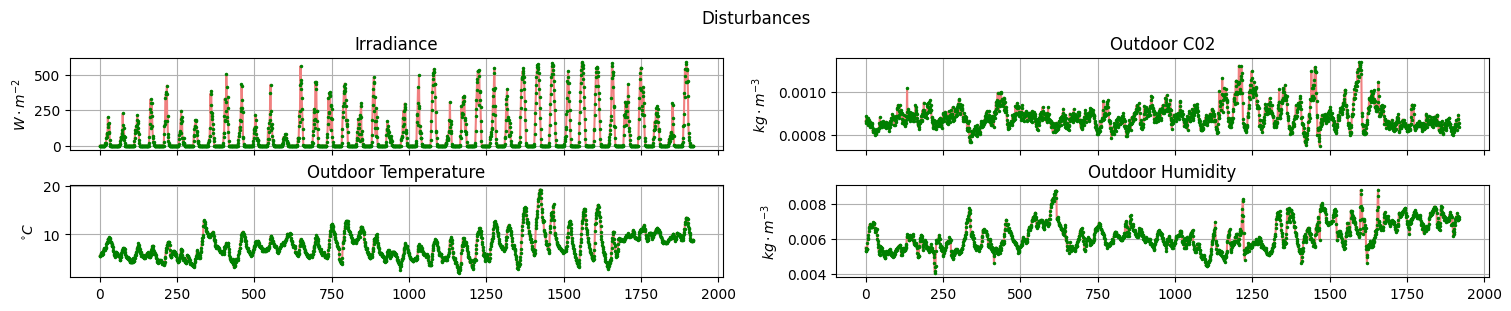

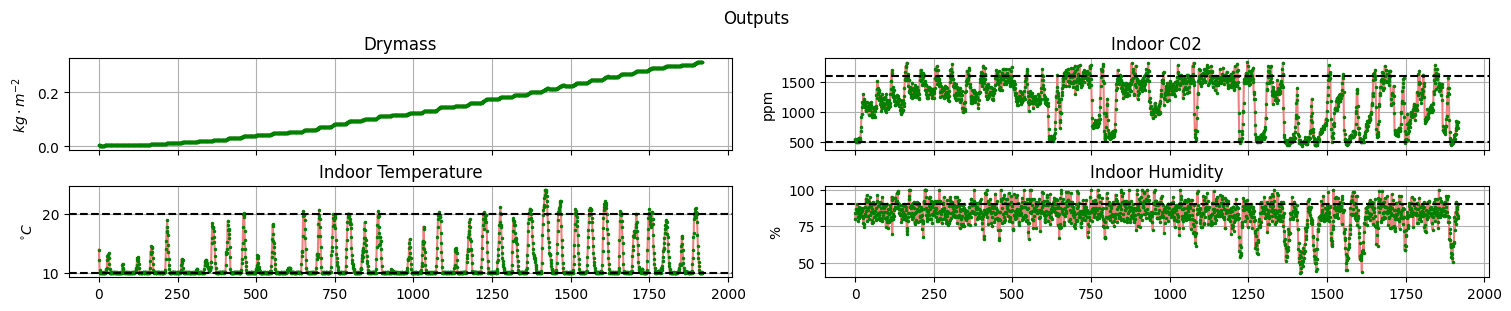

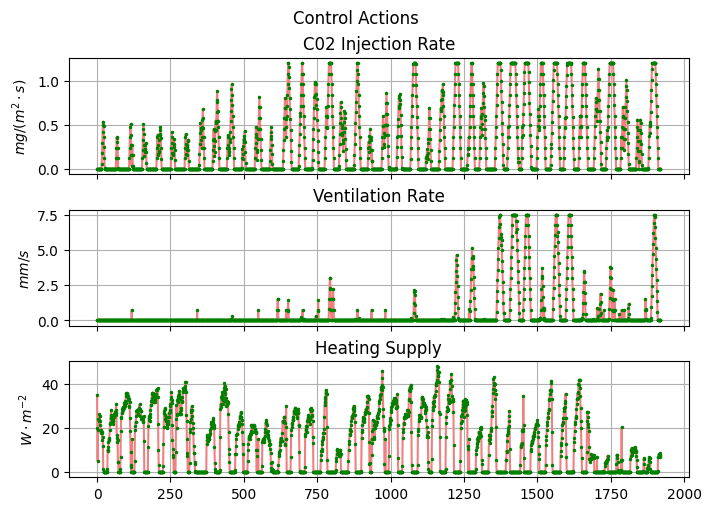

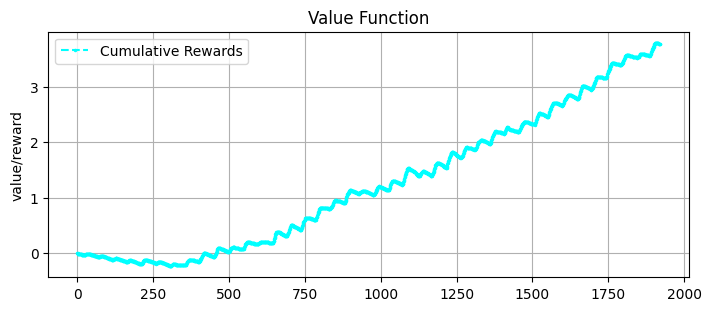

In [7]:
#Printing metrics
print (f"Total Reward/EPI: {total_reward}")#this should be the same or very similar to epi
print (f"Total Penalty: {total_penalty}")
print_metrics(Y_log[:-1], U_log, D_log, day_range=(0,40), rewards=np.array(cum_reward_log), time_log=comp_time_log)